In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio

In [2]:
import pandas as pd

Loading training data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
dfs_4 = pd.read_excel("/content/gdrive/My Drive/training_test_set.xlsx") # file mapping lever names to xpaths

In [5]:
# Load input samples and convert to Float Tensor
inputs = dfs_4.iloc[:, 0:48].to_numpy()
inputs = torch.tensor(inputs)
inputs = inputs.type(torch.FloatTensor)

In [6]:
# Load output samples and convert to Float Tensor
targets = dfs_4.iloc[:, 49:]
#targets=(targets-targets.mean())/targets.std() # Uncomment to enable output standardisation
targets = targets.to_numpy()
targets = torch.tensor(targets)
targets = targets.type(torch.FloatTensor)

Setting input to size 48

In [7]:
# Random input tensor to test the network
rand_tensor = torch.rand((1000, 48))
rand_tensor.size()

torch.Size([1000, 48])

Adapting network dimensions

In [101]:
# Initialise the network using fully connected layers and leaky Relus as activation function
def initialise_net():
    """
    Initialise feed forward neural network with 4 fully connected layers of size 48, 100, 70 and 55. 
    
    **Returns**:
    torch.nn
    """
  net = torch.nn.Sequential(
          torch.nn.Linear(48, 100),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(100, 100),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(100, 70),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(70, 55),
      )
  return net

In [133]:
initialise_net()

Sequential(
  (0): Linear(in_features=48, out_features=100, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=100, out_features=70, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=70, out_features=55, bias=True)
)

Generatinng a prediction

In [95]:
# Test network by passing sample input
prediction = net(inputs)
prediction.size()

torch.Size([3801, 55])

Define the loss function

In [ ]:
# Use a scale-free error metric, such as MAPE:
def my_loss(y_true, y_pred):  # Mean Absolute Percentual Error (MAPE)
    """
    Given the target and the current values, compute the Mean Absolute Percentage Error (MAPE).
    
    *Args*:
    
    - y_true(array): Target value. 
    - y_pred(array): Current value. 
    
    *Returns*:
    MAPE. 
    
    """
    return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100

Comparing the prediction to the target

In [134]:
# Calculate loss of random target pair
rand_target = torch.rand((1000, 55))
loss = my_loss(prediction, targets)     # must be (1. nn output, 2. target)
loss

tensor(105691.0391, grad_fn=<MulBackward0>)

Train the network with different learning rates

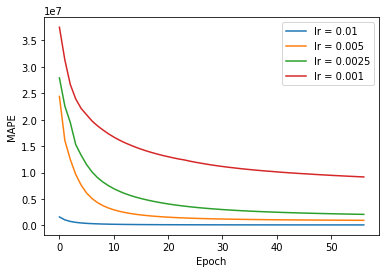

In [141]:
def iterate():
    """Minimise MAPE"""
    torch.manual_seed(28)    # To keep it reproducible
    x = inputs; y = targets # Relabel input and target variables
    x, y = Variable(x), Variable(y) # torch can only train on Variable, so convert them to Variable
    plt.figure()
    for learning_rate in [0.01, 0.005, 0.0025, 0.001]: # Test different learning rates (1D line search)
      net = initialise_net() # Initialise network
      optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
      #optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum = 0.7) # Uncomment to switch to SGD optimiser
      all_losses = []
      for t in range(100):  # Train por 100 epochs
          prediction = net(x)     # Input x and predict based on x
          loss = my_loss(prediction, y)     # Must be (1. nn output, 2. target)
          all_losses.append(loss)
          optimizer.zero_grad()   # Clear gradients for next training
          loss.backward()         # Perform backpropagation, compute gradients
          optimizer.step()        # Apply gradients
      # Plotting routine
      plt.plot(all_losses[3:60]) # 10:40
      plt.ylabel("MAPE")
      plt.xlabel("Epoch")
      plt.legend(["lr = 0.01", "lr = 0.005", "lr = 0.0025", "lr = 0.001"])
iterate()